In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import optimize

In [31]:
aero_data = {'species' : ['SO4', 'NO3', 'Cl', 'NH4', 'MSA', 'ARO1', 'ARO2', 'ALK1', 'OLE1', 'API1', 'API2', 'LIM1', 'LIM2', 'CO3', 'Na', 'Ca ', 'OIN', 'OC', 'BC', 'H2O'],
             'density' : [1800, 1800, 2200, 1800, 1800, 1400, 1400, 1400, 1400, 1400, 1400, 1400, 1400, 2600, 2200, 2600, 2600, 1000, 1800, 1000], #kg/m3
             'ions' : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             'molec_weight' : [96e-3, 62e-3, 35.5e-3, 18e-3, 95e-3, 150e-3,150e-3, 140e-3, 140e-3, 184e-3, 184e-3, 200e-3, 200e-3, 60e-3, 23e-3, 40e-3, 1e-3, 1e-3, 1e-3, 18e-3], # kg/mole
             'kappa' : [0.65, 0.65, 0.53, 0.65, 0.53, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.53, 0.53, 0.53, 0.1, 0.001, 0, 0]}
aero_file=pd.DataFrame(aero_data)

species = aero_file['species']
density = aero_file['density']
ions = aero_file['ions']
molec_weight = aero_file['molec_weight']
kappa = aero_file['kappa']

In [32]:
sgm_w = 72 * 1e-3 # N m-1
sgm_org = 40 * 1e-3 # N m-1
delta_min = 0.1 * 1e-9 # m 
Rv = 461  # J K-1 Kg-1
temp = 298 # K
rho_w = 1000   # Kg m-3
mw = 18 * 1e-3 # Kg mol-1

In [33]:
time = '13' 
df = pd.read_csv('/data/keeling/a/xx24/d/partmc/scenarios/1_urban_plume/do_coagulation/single_particle_000000'+time+'.csv', sep='\s+', header=None)
df = df.set_index(0)
data = df.T 
f = pd.DataFrame(data).reset_index(drop=True)

In [34]:
dry_diameters = f.dry_diameters
masses = f.masses 
dry_masses = f.dry_masses 
bc_masses = f.bc_masses 
oc_masses = f.oc_masses 
so4_masses = f.so4_masses 
no3_masses = f.no3_masses 
nh4_masses = f.nh4_masses 
soa_masses = f.soa_masses 
cl_masses = f.cl_masses 
msa_masses = f.msa_masses 
aro1_masses = f.aro1_masses 
aro2_masses = f.aro2_masses 
alk1_masses = f.alk1_masses 
ole1_masses = f.ole1_masses 
api1_masses = f.api1_masses 
api2_masses = f.api2_masses 
lim1_masses = f.lim1_masses 
lim2_masses = f.lim2_masses 
co3_masses = f.co3_masses 
na_masses = f.na_masses 
ca_masses = f.ca_masses 
oin_masses = f.oin_masses 
h2o_masses = f.h2o_masses 
crit_rhs = f.crit_rhs
scs = f.scs

In [35]:
v_SO4 = so4_masses/aero_file.iloc[0,1]
v_NO3 = no3_masses/aero_file.iloc[1,1]
v_Cl = cl_masses/aero_file.iloc[2,1]
v_NH4 = nh4_masses/aero_file.iloc[3,1]
v_MSA = msa_masses/aero_file.iloc[4,1]
v_ARO1 = aro1_masses/aero_file.iloc[5,1]
v_ARO2 = aro2_masses/aero_file.iloc[6,1]
v_ALK1 = alk1_masses/aero_file.iloc[7,1]
v_OLE1 = ole1_masses/aero_file.iloc[8,1]
v_API1 = api1_masses/aero_file.iloc[9,1]
v_API2 = api2_masses/aero_file.iloc[10,1]
v_LIM1 = lim1_masses/aero_file.iloc[11,1]
v_LIM2 = lim2_masses/aero_file.iloc[12,1]
v_CO3 = co3_masses/aero_file.iloc[13,1]
v_Na = na_masses/aero_file.iloc[14,1]
v_Ca = ca_masses/aero_file.iloc[15,1]
v_OIN = oin_masses/aero_file.iloc[16,1]
v_OC = oc_masses/aero_file.iloc[17,1]
v_BC = bc_masses/aero_file.iloc[18,1]
v_H2O = h2o_masses/aero_file.iloc[19,1]
v_total = v_SO4+v_NO3+v_Cl+v_NH4+v_MSA+v_ARO1+v_ARO2+v_ALK1+v_OLE1+v_API1+ \
          v_API2+v_LIM1+v_LIM2+v_CO3+v_Na+v_OIN+v_OC+v_BC+v_H2O
kappa_single = (v_SO4 * aero_file.iloc[0,4] + v_NO3 *  aero_file.iloc[1,4] + \
                v_Cl * aero_file.iloc[2,4] + v_NH4 * aero_file.iloc[3,4] + \
                v_MSA * aero_file.iloc[4,4] + v_ARO1 * aero_file.iloc[5,4] + \
                v_ARO2 * aero_file.iloc[6,4] + v_ALK1 * aero_file.iloc[7,4] + \
                v_OLE1 * aero_file.iloc[8,4] + v_API1 * aero_file.iloc[9,4] + \
                v_API2 * aero_file.iloc[10,4] + v_LIM1 * aero_file.iloc[11,4] + \
                v_LIM2 * aero_file.iloc[12,4] + v_CO3 * aero_file.iloc[13,4] + \
                v_Na * aero_file.iloc[14,4] + v_Ca * aero_file.iloc[15,4] + \
                v_OIN * aero_file.iloc[16,4] + v_OC * aero_file.iloc[17,4] + \
                v_BC * aero_file.iloc[18,4] + v_H2O * aero_file.iloc[19,4] )/v_total

In [36]:
v_dry = v_total - v_H2O
v_wet = v_total
v_org = v_OC+v_ARO1+v_ARO2+v_ALK1+v_OLE1+v_API1+v_API2+v_LIM1+v_LIM2
f_org = v_org/v_dry #fraction of orgranic

r_wet = ((3 * v_wet) / (4 * np.pi)) ** (1 / 3) # convert wet volume to wet radius
v_delta = v_wet - (((4 * np.pi) / 3) * (r_wet - delta_min) ** 3) # calculate the minimum shell volume, v_delta
v_beta = f_org * v_dry # calculate the total volume of organic, v_beta
c_beta = np.minimum(v_beta / v_delta, 1) # calculate the coverage parameter
sgm = (1 - c_beta) * sgm_w + c_beta * sgm_org # calculate sigma

$crit_{rh} = exp((2 * sgm / R_v / T / \rho_w) / r) * (r^3 - r_d^3) / (r^3 - r_d^3 * (1 - kappa))$ \
$r_{cr} = sqrt(3 * kappa * r_d^3 / (2 * \sigma / R_v / T / \rho_w))$

Text(0.5, 0, 'critical diameter $D_c (\\mu m)$')

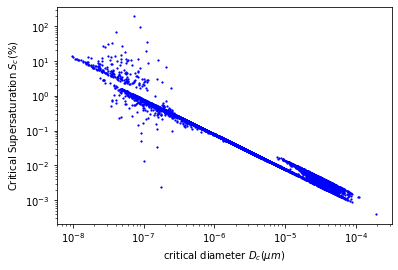

In [37]:
r_cr = np.sqrt(3 * kappa_single * (dry_diameters/2) **3 / (2 * sgm  / Rv / temp / rho_w))
cr_rhs =  np.exp((2 * sgm / Rv / temp / rho_w) / r_cr)* (r_cr ** 3 - (dry_diameters/2)**3) / (r_cr ** 3 - (dry_diameters/2)**3 * (1 - kappa_single))
plt.scatter(2*r_cr, (cr_rhs-1)*100, s=1.5, c='b')
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Critical Supersaturation $S_c (\%)$")
plt.xlabel("critical diameter $D_c (\mu m)$")

$f(D)=((D^3-D_{dry}^3\frac{2-\kappa}{2})^2-D_{dry}^6\frac{\kappa ^4}{2})+(-\frac{3D_{dry}^3{\kappa}}{A}D^4 )$ \
$f(D)=D^6-\frac{3D_{dry}^3\kappa}{A}D^4-D_{dry}^3(2-\kappa)D^3+D_{dry}^6(1-\kappa)$


In [38]:
capital_A = pd.Series(np.zeros(len(dry_diameters)))
c_1 = pd.Series(np.zeros(len(dry_diameters)))
c_2 = pd.Series(np.zeros(len(dry_diameters)))
c_3 = pd.Series(np.zeros(len(dry_diameters)))
crit_radius = pd.Series(np.zeros(len(dry_diameters)))
crit_ss = pd.Series(np.zeros(len(dry_diameters)))

Text(0.5, 0, 'critical diameter')

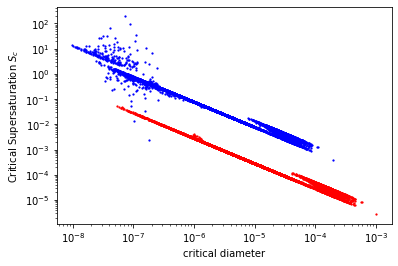

In [39]:
for i in range(len(dry_diameters)):
    capital_A[i] = (4 * mw * sgm[i])/(Rv * temp * rho_w) 
    c_1[i] = -(3 * (dry_diameters[i]/2) ** 3 * kappa_single[i])/capital_A[i]
    c_2[i] = -(dry_diameters[i]/2) ** 3 * (2 - kappa_single[i])
    c_3[i] = (dry_diameters[i]/2) ** 6 * (1 - kappa_single[i])
    func = lambda  x: x ** 6 + c_1[i] * (x ** 4) + c_2[i] * (x **3) + c_3[i]
    df = lambda x: 6 * x ** 5 + 4 * c_1[i] * x **3 + 3 * c_2[i] * x **2 
    ddf = lambda x: 30 * x ** 4 + 12 * c_1[i] * x **2 + 6 * c_2[i] * x
    crit_radius[i] = scipy.optimize.brentq(func, dry_diameters[i]/2, 1, xtol=1e-14, rtol=8.881784197001252e-16, maxiter=100, full_output=False, disp=True)
    crit_ss[i] = ((crit_radius[i]**3 -(dry_diameters[i]/2)**3)/(crit_radius[i]**3 - (dry_diameters[i]/2)**3 * (1-kappa_single[i])))*np.exp(capital_A[i]/crit_radius[i])

plt.scatter(2*crit_radius, (crit_ss-1)*100, s=1.5, c= 'r')
plt.scatter(2*r_cr, (cr_rhs-1)*100, s=1.5, c='b')
# plt.scatter(dry_diameters,scs*100, s=1.5, c='k')
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Critical Supersaturation $S_c $")
plt.xlabel("critical diameter")

Text(0.5, 0, 'Dry Diameter')

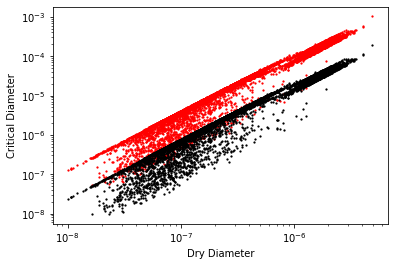

In [40]:
plt.scatter(dry_diameters, 2*crit_radius,s=1.5, c = 'r')
plt.scatter(dry_diameters, 2*r_cr,s=1.5, c = 'k')
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Critical Diameter")
plt.xlabel("Dry Diameter")